In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS

from ztf_shift_utils import *

plt.style.use(astropy_mpl_style)

Querying: https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0206/287824/ztf_20200206287824_000819_zg_c13_o_q2_sciimg.fits
Querying: https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0206/302627/ztf_20200206302627_000819_zg_c13_o_q2_sciimg.fits
Making SExtractor catalog of 20200206287824_000819_sciimg.fits...
This catalogue already exists, moving on...
Making SExtractor catalog of 20200206302627_000819_sciimg.fits...
This catalogue already exists, moving on...
Matching catalogs...


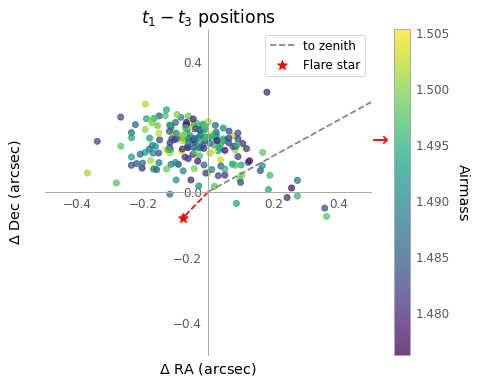

In [2]:
#Define epochs
mjd1 = 58885.28807871
mjd2 = 58885.3026273

#Read in images
ep1file = getsciimg(filefracday = '20200206287824', paddedfield = '000819', filtercode = 'zg', 
                    paddedccdid = '13', imgtypecode = 'o', qid = '2')
ep2file = getsciimg(filefracday = '20200206302627', paddedfield = '000819', filtercode = 'zg', 
                    paddedccdid = '13', imgtypecode = 'o', qid = '2')

#Run SExtractor on images (or just read in catalogs if they exist already)
ep1cat = srcext('20200206287824_000819_sciimg.fits', 
                det_thresh = 10, ana_thresh = 10, catname = '20200206287824_000819.cat')
ep2cat = srcext('20200206302627_000819_sciimg.fits', 
                det_thresh = 10, ana_thresh = 10, catname = '20200206302627_000819.cat')

#Crossmatch catalogs
ind, d2d, d3d = xmatch(ep1cat, ep2cat)

#Discard unmatched stars in ep2cat
ep1ra = ep1cat["ALPHA_SKY"].values
ep1dec = ep1cat["DELTA_SKY"].values
ep2ra = ep2cat["ALPHA_SKY"].values[ind]
ep2dec = ep2cat["DELTA_SKY"].values[ind]

#Calculate zenith locations
zen1 = calc_zenith(mjd1)
zen2 = calc_zenith(mjd2)
zen_ra = zen2.ra.value
zen_dec = zen2.dec.value

#ID the flaring star
flr_ra = 186.09002468556912
flr_dec = 65.31234685437119
flr_ind = np.where((np.abs(ep1ra - flr_ra) == np.abs(ep1ra - flr_ra).min()) * 
                 (np.abs(ep1dec - flr_dec) == np.abs(ep1dec - flr_dec).min()))[0][0]

#Compute airmasses-------------------------
ep1am = np.zeros(len(ep1ra))
ep2am = np.zeros(len(ep2ra))

i = 0
j = 0
for ra, dec in zip(ep1ra, ep1dec):

    mtn = EarthLocation.of_site('Palomar')
    mjd = Time(mjd1, format = 'mjd')
    flraltaz = SkyCoord(ra = ra * u.degree, dec = dec*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
    zd = 90 - flraltaz.alt.value
    ep1am[i] = 1 / np.cos(np.deg2rad(zd))
    i+=1

for ra, dec, am in zip(ep2ra, ep2dec, ep2am):

    mtn = EarthLocation.of_site('Palomar')
    mjd = Time(mjd2, format = 'mjd')
    flraltaz = SkyCoord(ra = ra * u.degree, dec = dec*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
    zd = 90 - flraltaz.alt.value
    ep2am[j] = 1 / np.cos(np.deg2rad(zd))
    j+=1

mean_ams = (ep1am + ep2am) / 2
#--------------------------------------------

#Calc delta positions, conv to arcsec
d_ra = (ep1ra - ep2ra) * 3600
d_dec = (ep1dec - ep2dec) * 3600

#Calc zenith delta position, conv to arcsec
d_zra = (ep1ra.mean() - zen_ra) * 3600
d_zdec = (ep1dec.mean() - zen_dec) * 3600


#Plotting-----------------------------------
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
s = ax.scatter(d_ra, d_dec, c=mean_ams, cmap='viridis', alpha=0.75)
ax.scatter(d_ra[flr_ind], d_dec[flr_ind], color='red', s=100, marker='*', label='Flare star')
ax.plot([0,d_zra],[0,d_zdec], c='gray',ls='--', label="to zenith")
ax.plot([0,d_ra[flr_ind]],[0,d_dec[flr_ind]], c='red',ls='--')
cbar = fig.colorbar(s)
cbar.set_label('Airmass', rotation=270, labelpad=20)
cbar.ax.text(1.45, mean_ams[flr_ind], s=r'$\rightarrow$', fontsize=20, color='red', 
             ha='center', va='center', label='Flare star airmass')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlabel(r"$\Delta$ RA (arcsec)", labelpad=150)
ax.set_ylabel(r"$\Delta$ Dec (arcsec)", labelpad=150)
ax.set_title(r'$t_1 - t_3$ positions')
ax.set_xticks([-0.4,-0.2,0.2,0.4])
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.legend()
ax.grid(False)

plt.gca().set_aspect('equal')